In [1]:
%pip install pandas-geojson
%pip install reverse_geocoder
%pip install swifter
%pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268066 sha256=ddf34646e360e430a077f44218f0563e2051ce1dd3b865898c6a0b6247b2ae27
  Stored in directory: /root/.cache/pip/wheels/bd/e5/88/eb139b6d6a26b8022d370ab991f7a836802fed9871975ec6d9
Successfully built reverse_geocoder
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 16.6 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=0ef1deb65aa9e20a0828721ac23405cfc6724bd8fac8aca296e76a9ace7f6922
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972

In [2]:
import pandas as pd
import re
import plotly.graph_objects as go # to plot heatmaps
import matplotlib.pyplot as plt
import pandas_geojson as pdg
import reverse_geocoder
import numpy as np
import swifter
import seaborn as sns

In [3]:
# https://github.com/fivethirtyeight/data/tree/master/food-world-cup
df = pd.read_csv("/content/drive/MyDrive/restaurants/food-world-cup-data.csv", encoding="latin1")

## Data normalizing and cleansing

In [4]:
def rename_rating_columns(column_name):
  if column_name.startswith("Please rate"):
    m = re.search("([A-Za-z]+).?$", column_name)
    if m:
      return "rating_%s" % m.group(1).lower()
    else:
      print(column_name)
    return
  else:
    return column_name

In [5]:
df = df.rename(rename_rating_columns, axis='columns')
df = df.rename(str.lower, axis='columns')
df = df.rename(columns={df.columns[0]: "respondent", df.columns[1]: "knowlegde", df.columns[2]: "interest" , df.columns[45]: "household_income", df.columns[47]: "region" })

In [6]:
df.head()

,respondent,knowlegde,interest,rating_algeria,rating_argentina,rating_australia,rating_belgium,rating_herzegovina,rating_brazil,rating_cameroon,...,rating_turkey,rating_cuba,rating_ethiopia,rating_vietnam,rating_ireland,gender,age,household_income,education,region
0,3308895255,Intermediate,Some,NaN,3.0,5.0,4.0,NaN,3.0,NaN,...,NaN,NaN,3.0,NaN,4.0,Male,18-29,"$100,000 - $149,999",Less than high school degree,West South Central
1,3308891308,Novice,Some,NaN,NaN,3.0,3.0,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,4.0,Male,18-29,"$100,000 - $149,999",Some college or Associate degree,West South Central
2,3308891135,Intermediate,A lot,3.0,4.0,NaN,3.0,NaN,4.0,5.0,...,NaN,4.0,5.0,4.0,3.0,Male,30-44,"$50,000 - $99,999",Graduate degree,Pacific
3,3308879091,Novice,Not muchÊ,NaN,3.0,NaN,3.0,NaN,NaN,3.0,...,3.0,4.0,NaN,4.0,3.0,Male,45-60,"$0 - $24,999",Less than high school degree,New England
4,3308871671,Novice,Not muchÊ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,3.0,NaN,Male,30-44,"$25,000 - $49,999",High school degree,Pacific


In [7]:
df.groupby("age")["rating_germany"].agg(["mean","count","size"])

,mean,count,size
age,,,
18-29,3.550265,189,262
30-44,3.406250,256,307
45-60,3.345070,284,345
> 60,3.565972,288,325


In [8]:
df.groupby("age")["rating_china"].agg(["mean","count","size"])

,mean,count,size
age,,,
18-29,3.566667,240,262
30-44,3.627240,279,307
45-60,3.764331,314,345
> 60,3.768966,290,325


In [9]:
regions = df.groupby("region")["rating_china"].agg(["mean","count","size"]).reset_index()

In [10]:
# https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
census_regions = {
    "Mountain": ["Arizona", "Colorado", "Idaho", "New Mexico", "Montana", "Utah", "Nevada", "Wyoming"],
    "East North Central": ["Indiana", "Illinois", "Michigan", "Ohio", "Wisconsin"],
    "East South Central": ["Alabama", "Kentucky", "Mississippi", "Tennessee"],
    "Middle Atlantic": ["New Jersey" ,"New York", "Pennsylvania"],
    "New England": ["Connecticut" , "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont"],
    "Pacific": ["Alaska","California","Hawaii","Oregon","Washington"],
    "South Atlantic": ["Delaware", "District of Columbia","Florida","Georgia","Maryland","North Carolina","South Carolina","Virginia", "West Virginia"],
    "West North Central": ["Arkansas","Louisiana","Oklahoma","Texas"],
    "West South Central": ["Iowa", "Nebraska", "Kansas", "North Dakota", "Minnesota", "South Dakota", "Missouri"],
}

In [11]:
regions["states"] = regions["region"].map(census_regions)

In [12]:
regions

,region,mean,count,size,states
0,East North Central,3.559524,168,188,"[Indiana, Illinois, Michigan, Ohio, Wisconsin]"
1,East South Central,3.583333,36,40,"[Alabama, Kentucky, Mississippi, Tennessee]"
2,Middle Atlantic,3.668790,157,170,"[New Jersey, New York, Pennsylvania]"
3,Mountain,3.695652,92,102,"[Arizona, Colorado, Idaho, New Mexico, Montana..."
4,New England,3.612903,62,73,"[Connecticut, Maine, Massachusetts, New Hampsh..."
5,Pacific,3.762376,202,215,"[Alaska, California, Hawaii, Oregon, Washington]"
6,South Atlantic,3.683333,180,200,"[Delaware, District of Columbia, Florida, Geor..."
7,West North Central,3.868132,91,107,"[Arkansas, Louisiana, Oklahoma, Texas]"
8,West South Central,3.755906,127,134,"[Iowa, Nebraska, Kansas, North Dakota, Minneso..."


In [13]:
states = regions.explode("states").drop("region", axis=1)

In [14]:
# https://gist.github.com/mshafrir/2646763
raw = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AS": "American Samoa",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "DC": "District Of Columbia",
    "FM": "Federated States Of Micronesia",
    "FL": "Florida",
    "GA": "Georgia",
    "GU": "Guam",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MH": "Marshall Islands",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "MP": "Northern Mariana Islands",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PW": "Palau",
    "PA": "Pennsylvania",
    "PR": "Puerto Rico",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VI": "Virgin Islands",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming"
}
state_codes = dict((v,k) for k,v in raw.items())

In [15]:
states["state_code"] = states["states"].map(state_codes)

In [16]:
states.head()

,mean,count,size,states,state_code
0,3.559524,168,188,Indiana,IN
0,3.559524,168,188,Illinois,IL
0,3.559524,168,188,Michigan,MI
0,3.559524,168,188,Ohio,OH
0,3.559524,168,188,Wisconsin,WI


In [17]:
# many of the steps for plotting heatmaps are repetitive, this function takes care of that
# input: a dataframe df and a variable in df that you wish to plot
# output: None. A heatmap will be plotted directly.
def plot_heatmap(df, var):
    # plotting the heatmap by states
    fig = go.Figure(data=go.Choropleth(
        locations=df['state_code'], # Spatial coordinates
        z = df[var].astype(float), # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = 'Reds',
        colorbar_title = var,
        text = df['states']
    ))

    fig.update_layout(
        title_text = var + ' by state<br>(Hover over the states for details)',
        geo_scope='usa', # limit map scope to USA
    )

    fig.show()

In [18]:
regions

,region,mean,count,size,states
0,East North Central,3.559524,168,188,"[Indiana, Illinois, Michigan, Ohio, Wisconsin]"
1,East South Central,3.583333,36,40,"[Alabama, Kentucky, Mississippi, Tennessee]"
2,Middle Atlantic,3.668790,157,170,"[New Jersey, New York, Pennsylvania]"
3,Mountain,3.695652,92,102,"[Arizona, Colorado, Idaho, New Mexico, Montana..."
4,New England,3.612903,62,73,"[Connecticut, Maine, Massachusetts, New Hampsh..."
5,Pacific,3.762376,202,215,"[Alaska, California, Hawaii, Oregon, Washington]"
6,South Atlantic,3.683333,180,200,"[Delaware, District of Columbia, Florida, Geor..."
7,West North Central,3.868132,91,107,"[Arkansas, Louisiana, Oklahoma, Texas]"
8,West South Central,3.755906,127,134,"[Iowa, Nebraska, Kansas, North Dakota, Minneso..."


In [19]:
plot_heatmap(states, "mean")

In [20]:
df.groupby(["age", "gender", "household_income"])["rating_china"].agg(["mean","count","size"]).sort_values(by=["mean"])

mean  count  size
age   gender household_income                          
18-29 Female $150,000+            2.833333      6     7
      Male   $150,000+            3.222222      9     9
      Female $0 - $24,999         3.296296     27    29
30-44 Female $150,000+            3.384615     13    13
      Male   $0 - $24,999         3.400000     10    14
             $150,000+            3.428571     14    14
             $100,000 - $149,999  3.450000     20    21
> 60  Female $100,000 - $149,999  3.466667     15    16
30-44 Female $50,000 - $99,999    3.472222     36    39
18-29 Male   $100,000 - $149,999  3.500000     12    12
30-44 Male   $25,000 - $49,999    3.517241     29    31
> 60  Female $0 - $24,999         3.571429      7    10
18-29 Female $25,000 - $49,999    3.575758     33    36
30-44 Female $100,000 - $149,999  3.600000     20    20
             $25,000 - $49,999    3.600000     30    31
18-29 Male   $0 - $24,999         3.600000     30    32
> 60  Female $50,000 - $99,999    3.608696     46    48
18-29 Male   $50,000 - $99,999    3.608696     23    27
45-60 Female $50,000 - $99,999    3.630435     46    51
> 60  Male   $50,000 - $99,999    3.650000     40    44
18-29 Female $100,000 - $149,999  3.666667      9     9
             $50,000 - $99,999    3.666667     18    23
45-60 Male   $25,000 - $49,999    3.666667     24    25
> 60  Female $25,000 - $49,999    3.696970     33    38
45-60 Female $100,000 - $149,999  3.703704     27    27
> 60  Male   $25,000 - $49,999    3.800000     10    16
30-44 Male   $50,000 - $99,999    3.871795     39    44
45-60 Female $0 - $24,999         3.875000      8    14
18-29 Male   $25,000 - $49,999    3.888889     18    19
> 60  Male   $0 - $24,999         3.888889      9    11
45-60 Female $25,000 - $49,999    3.928571     14    14
      Male   $100,000 - $149,999  3.933333     30    33
      Female $150,000+            3.947368     19    19
      Male   $150,000+            3.947368     19    23
             $50,000 - $99,999    3.947368     38    44
> 60  Male   $100,000 - $149,999  4.000000     21    23
      Female $150,000+            4.055556     18    18
      Male   $150,000+            4.095238     21    22
45-60 Male   $0 - $24,999         4.230769     13    13
30-44 Female $0 - $24,999         4.363636     11    15

In [21]:
# https://data.census.gov/table?q=Population%20Total%20state
census_states_total_df = pd.read_csv("/content/drive/MyDrive/restaurants/DECENNIALCD1182020.P1-2024-09-04T202238.csv")

In [22]:
census_states_total_df

,Label (Grouping),Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Puerto Rico
0,Total,"5,024,279","733,391","7,151,502","3,011,524","39,538,223","5,773,714","3,605,944","989,948","689,545",...,"6,910,840","29,145,505","3,271,616","643,077","8,631,393","7,705,281","1,793,716","5,893,718","576,851","3,285,874"


In [23]:
census_states_asian_df = pd.read_csv("/content/drive/MyDrive/restaurants/ACSSPP1Y2022.S0201-2024-09-04T202039.csv")

In [24]:
def rename_state_columns(column_name):
  m = re.search("^([A-Za-z ]+)!!", column_name)
  if m:
    return m.group(1)
  else:
    return column_name

In [25]:
census_states_asian_df = census_states_asian_df.rename(rename_state_columns, axis='columns')

In [26]:
census_states_asian_df

,Label (Grouping),Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Florida,Georgia,...,Oklahoma,Oregon,Pennsylvania,South Carolina,Tennessee,Texas,Utah,Virginia,Washington,Wisconsin
0,TOTAL NUMBER OF RACES REPORTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Total population,"111,795","66,732","369,675","67,838","7,067,135","292,259","214,181","872,174","591,612",...,"130,527","288,867","598,781","125,957","181,166","1,953,033","130,531","753,832","988,085","218,713"
2,One race,70.6%,69.2%,72.1%,72.1%,85.7%,65.1%,81.7%,73.4%,82.0%,...,71.8%,67.3%,82.1%,71.9%,73.8%,83.9%,64.6%,81.0%,77.2%,79.2%
3,Two races,23.5%,24.3%,21.6%,22.0%,11.9%,29.3%,14.8%,21.4%,14.9%,...,22.3%,27.0%,15.7%,23.1%,22.0%,13.0%,27.7%,16.0%,18.9%,18.4%
4,Three races,4.7%,5.8%,5.6%,3.9%,2.0%,5.1%,2.9%,4.3%,2.1%,...,5.0%,4.6%,1.6%,4.6%,3.3%,2.6%,6.6%,2.5%,3.4%,2.0%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,Median gross rent (dollars),"1,080","1,298","1,592",941,"2,101","1,756","1,543","1,645","1,626",...,982,"1,519","1,420","1,296","1,357","1,515","1,431","1,804","1,928","1,112"
341,COMPUTERS AND INTERNET USE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
342,Total households,"33,712","17,997","116,606","20,881","2,293,306","95,303","68,239","278,077","194,383",...,"42,157","96,463","195,143","40,257","55,847","643,977","37,010","235,348","339,255","65,191"
343,With a computer,97.0%,98.6%,97.5%,96.8%,98.0%,98.5%,98.8%,98.4%,99.0%,...,98.2%,97.4%,98.2%,99.5%,98.6%,98.6%,99.1%,99.0%,98.7%,99.0%


In [27]:
census_states_asian_df = census_states_asian_df.loc[1].reset_index().iloc[1: , :].rename(columns={"index": "states", 1: "asian"})

In [28]:
census_states_total_df = census_states_total_df.loc[0].reset_index().iloc[1: , :].rename(columns={"index": "states", 0: "total"})

In [29]:
census_states_df = census_states_asian_df.merge(census_states_total_df, on="states", how="right")
census_states_df["state_code"] = census_states_df["states"].map(state_codes)
census_states_df["asian"] = census_states_df["asian"].str.replace(",", "").astype('Int32')
census_states_df["total"] = census_states_df["total"].str.replace(",", "").astype('Int32')
census_states_df["asian_percentage"] = census_states_df["asian"] / census_states_df["total"]

In [30]:
census_states_df

,states,asian,total,state_code,asian_percentage
0,Alabama,111795,5024279,AL,0.022251
1,Alaska,66732,733391,AK,0.090991
2,Arizona,369675,7151502,AZ,0.051692
3,Arkansas,67838,3011524,AR,0.022526
4,California,7067135,39538223,CA,0.178742
5,Colorado,292259,5773714,CO,0.050619
6,Connecticut,214181,3605944,CT,0.059397
7,Delaware,<NA>,989948,DE,<NA>
8,District of Columbia,<NA>,689545,NaN,<NA>
9,Florida,872174,21538187,FL,0.040494


In [31]:
plot_heatmap(census_states_df, "asian_percentage")

In [32]:
def lat_long_to_state(coordinates):
  #get the metadata for the latitude and longitude coordinates
  results = reverse_geocoder.search((coordinates[1], coordinates[0]))
  #check if the location is a US state (the 'admin1' variable is where US states are listed)
  if results[0]['admin1'] in state_codes:
    return results[0]['admin1']
  else:
    return np.nan

In [33]:
def read_restaurant_geodata(path):
  geojson = pdg.read_geojson(path)
  _res_df = geojson.to_dataframe()
  _res_df["states"] = _res_df["geometry.coordinates"].swifter.apply(lat_long_to_state)
  _res_df["state_code"] = _res_df["states"].map(state_codes)
  return _res_df.set_index("properties.@id")

In [34]:
# https://overpass-turbo.eu/ Open Street Map data
# _chinese_restaurants_dfs = [read_restaurant_geodata('/content/drive/MyDrive/restaurants/export.geojson')]
# _chinese_restaurants_dfs.append(read_restaurant_geodata('/content/drive/MyDrive/restaurants/export_2.geojson'))
# _chinese_restaurants_dfs.append(read_restaurant_geodata('/content/drive/MyDrive/restaurants/export_3.geojson'))
# _chinese_restaurants_dfs.append(read_restaurant_geodata('/content/drive/MyDrive/restaurants/export_alaska.geojson'))
# _chinese_restaurants_dfs.append(read_restaurant_geodata('/content/drive/MyDrive/restaurants/export_hawaii.geojson'))
# chinese_restaurants = pd.concat(_chinese_restaurants_dfs).set_index("properties.@id")


In [35]:
chinese_restaurants_backup_path = "/content/drive/MyDrive/restaurants/chinese_restaurants.arrow"

In [36]:
# save data as arrow as reverse geolookup is slow
# chinese_restaurants.write_feather(chinese_restaurants_backup_path)

In [37]:
chinese_restaurants = pd.read_feather(chinese_restaurants_backup_path)

In [38]:
chinese_restaurants.head()

,type,geometry.type,geometry.coordinates,properties.amenity,properties.cuisine,properties.name,properties.phone,properties.addr:unit,properties.created_by,properties.note,...,properties.website:order,properties.dish,properties.strapline,properties.payment:alipay,properties.payment:wechat,properties.opening_hours:delivery,properties.sport,properties.diet:poultry,properties.website:reservation,properties.ref
properties.@id,,,,,,,,,,,,,,,,,,,,,
node/251842657,Feature,Point,"[-114.4340203, 49.6074562]",restaurant,chinese,Ben Wong Restaurant,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
node/251842747,Feature,Point,"[-114.4456662, 49.6090797]",restaurant,chinese,51RT,+1-403-564-4403,None,None,None,...,None,None,None,None,None,None,None,None,None,None
node/266671565,Feature,Point,"[-122.0374992, 37.3684685]",restaurant,chinese,Ginger Cafe,None,114,None,None,...,None,None,None,None,None,None,None,None,None,None
node/276540072,Feature,Point,"[-117.2244316, 32.8626893]",restaurant,chinese,Shanghai Cafe,None,None,Potlatch 0.9c,None,...,None,None,None,None,None,None,None,None,None,None
node/305504469,Feature,Point,"[-112.0256581, 41.1684617]",restaurant,chinese,ABC Mandarin,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [39]:
chinese_restaurants_per_state = chinese_restaurants.groupby(["state_code", "states"]).size().reset_index().rename(columns={0: "cnt_chinese_restaurants"})

In [40]:
chinese_restaurants_per_state.head()

,state_code,states,cnt_chinese_restaurants
0,AK,Alaska,13
1,AL,Alabama,57
2,AR,Arkansas,14
3,AZ,Arizona,98
4,CA,California,987


In [41]:
plot_heatmap(chinese_restaurants_per_state, "cnt_chinese_restaurants")

In [42]:
combined_state_data = census_states_df.merge(chinese_restaurants_per_state, on=["state_code","states"], how="right").merge(states, on=["state_code","states"], how="right")
combined_state_data["chinese_restaurants_per_1K"] = combined_state_data["cnt_chinese_restaurants"] / combined_state_data["total"] * 1000

In [43]:
plot_heatmap(combined_state_data, "chinese_restaurants_per_1K")

In [44]:
combined_state_data.head()

,states,asian,total,state_code,asian_percentage,cnt_chinese_restaurants,mean,count,size,chinese_restaurants_per_1K
0,Indiana,218761,6785528,IN,0.032239,96.0,3.559524,168,188,0.014148
1,Illinois,881764,12812508,IL,0.068821,238.0,3.559524,168,188,0.018576
2,Michigan,422772,10077331,MI,0.041953,184.0,3.559524,168,188,0.018259
3,Ohio,376575,11799448,OH,0.031915,246.0,3.559524,168,188,0.020848
4,Wisconsin,218713,5893718,WI,0.03711,118.0,3.559524,168,188,0.020021


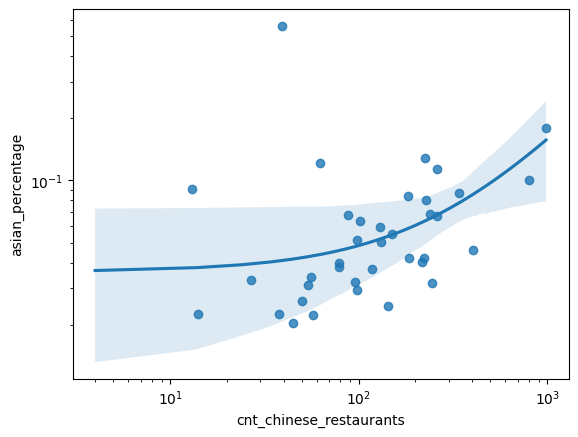

In [45]:
# sns.scatterplot(data=combined_state_data, x="cnt_chinese_restaurants", y="asian_percentage")
combined_state_data["asian_percentage"] = combined_state_data["asian_percentage"].fillna(0).astype(float)
sns.regplot(x="cnt_chinese_restaurants", y="asian_percentage", data=combined_state_data)
plt.xscale('log')
plt.yscale('log')

<Axes: xlabel='cnt_chinese_restaurants', ylabel='mean'>

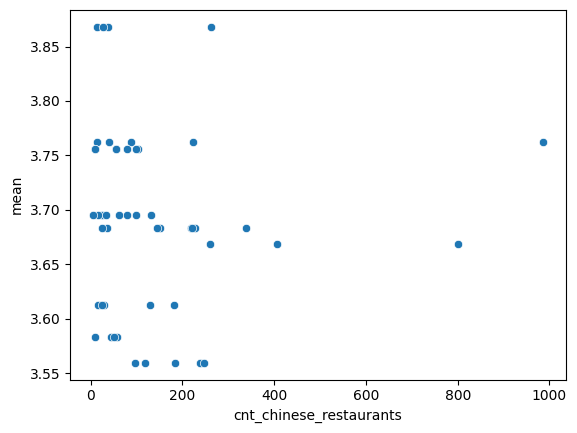

In [46]:
sns.scatterplot(data=combined_state_data, x="cnt_chinese_restaurants", y="mean")

In [47]:
def min_max_norm(df, col):
  return (df[col] - df[col].min())/(df[col].max()-df[col].min())

In [48]:
def mean_normalize(df, col):
  return (df[col] - df[col].mean())/ df[col].std()

In [49]:
combined_state_data["asian_percentage_norm"] = min_max_norm(combined_state_data, "asian_percentage")
combined_state_data["chinese_rating_norm"] = min_max_norm(combined_state_data, "mean")
combined_state_data["chinese_restaurants_norm"] = min_max_norm(combined_state_data, "chinese_restaurants_per_1K")
combined_state_data["score"] = ((combined_state_data["asian_percentage_norm"] / 4) * (combined_state_data["chinese_rating_norm"] * (1 - combined_state_data["chinese_restaurants_norm"]) * 4)) / 3

In [67]:
combined_state_data.head()

,states,asian,total,state_code,asian_percentage,cnt_chinese_restaurants,mean,count,size,chinese_restaurants_per_1K,asian_percentage_norm,chinese_rating_norm,chinese_restaurants_norm,score
0,Indiana,218761,6785528,IN,0.032239,96.0,3.559524,168,188,0.014148,0.057718,0.0,0.296929,0.0
1,Illinois,881764,12812508,IL,0.068821,238.0,3.559524,168,188,0.018576,0.123210,0.0,0.418995,0.0
2,Michigan,422772,10077331,MI,0.041953,184.0,3.559524,168,188,0.018259,0.075108,0.0,0.410262,0.0
3,Ohio,376575,11799448,OH,0.031915,246.0,3.559524,168,188,0.020848,0.057137,0.0,0.481653,0.0
4,Wisconsin,218713,5893718,WI,0.037110,118.0,3.559524,168,188,0.020021,0.066437,0.0,0.458851,0.0


In [51]:
plot_heatmap(combined_state_data, "score")

In [53]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [71]:
names =chinese_restaurants["properties.name"]
# Join the different processed titles together.
long_string = ' '.join(list(chinese_restaurants["properties.name"].dropna().values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color="steelblue", width=1200, height=800, collocations=False)# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_file("/content/drive/MyDrive/restaurants/chinese_restaurants.png")